# Introduction

Notebook designed to unite databases and perform statistical modeling

# Imports and Configuration

In [1]:
%load_ext rpy2.ipython

In [2]:
%reload_ext autoreload
%autoreload 2

import sys
import os
import logging
import warnings
import datetime
import pytz
#import pickle
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx 
import osmnx as ox
import matplotlib.pyplot as plt
import random

from matplotlib import colors, cm
from pathlib import Path 
from shapely.geometry import Point, Polygon, box
from IPython.display import display, Markdown
#from scipy.spatial import cKDTree
from mpl_toolkits.axes_grid1 import make_axes_locatable

from datetime import datetime as dt
from datetime import timedelta as td

# Setting matplotlib font size
plt.rcParams.update({'font.size': 14})
pd.set_option('display.max_columns', None)

current_path = Path().resolve()
abs_path = str(current_path.parent)
sys.path.append(abs_path)

warnings.filterwarnings("ignore")

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.getLogger('boto3').setLevel(logging.CRITICAL)
logging.getLogger('botocore').setLevel(logging.CRITICAL)


In [3]:
import scripts.pot_holes_cost as phc
from scripts.model_eval import *

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

In [5]:
city = 'Miraflores'
table = 'pe_lima_waze_alerts'
start_date = dt(2018,10,2) #rj starts at 12/12
end_date = dt(2019,8,26)
osm_place = "Distrito de Miraflores"
which_result=1

lat_centr_point, lon_centr_point = -12.1162673,-77.0306933

RAW_PATH = current_path.parent / 'data' / 'raw' / city
OUTPUT_PATH = current_path.parent / 'data' / 'output' / city

if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

# Getting the Data

## Floods

The data related to the floods were extracted from our Big Data server which stores the Waze information. Flood alerts are created by the application's own users to alert others of the road conditions.

In [6]:
flood = pd.read_csv(RAW_PATH/'Athena-flood-Miraflores.csv')

In [7]:
flood = phc.treat_alerts_points(flood)
flood['date'] = flood['start_time'].apply(dt.fromisoformat).apply(dt.date).apply(pd.to_datetime)

## Open Street Maps (OSM)

To complement our study, we downloaded the city street information available on Open Street Maps, a collaborative mapping project to create a free, editable map of the world. With a network of more than 2 million collaborators around the world, OSM offers detailed maps of various locations and is an excellent source of information on the road structure of municipalities.

In [8]:
if osm_place:
    G = phc.download_osm_graph(city, osm_place, simplify=False, which_result=which_result)
else:
    lats = flood['latitude'].values
    longs = flood['longitude'].values
    north, south, east, west = max(lats), min(lats), max(longs), min(longs)
    G = phc.download_osm_graph(city, north=north, south=south, east=east, west=west, simplify=False, cached=False, cache_result=False)

In [9]:
G_proj = ox.project_graph(G) 

The image below shows all public roads in the city registered with the OSM.

In [10]:
fig, ax = ox.plot_graph(G_proj, node_size=0, fig_height=10, show=False, axis_off=False, edge_linewidth=0.2)
ax.margins(0)
ax.tick_params(which='both', left=False, bottom=False,  labelleft=False, labelbottom=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False);

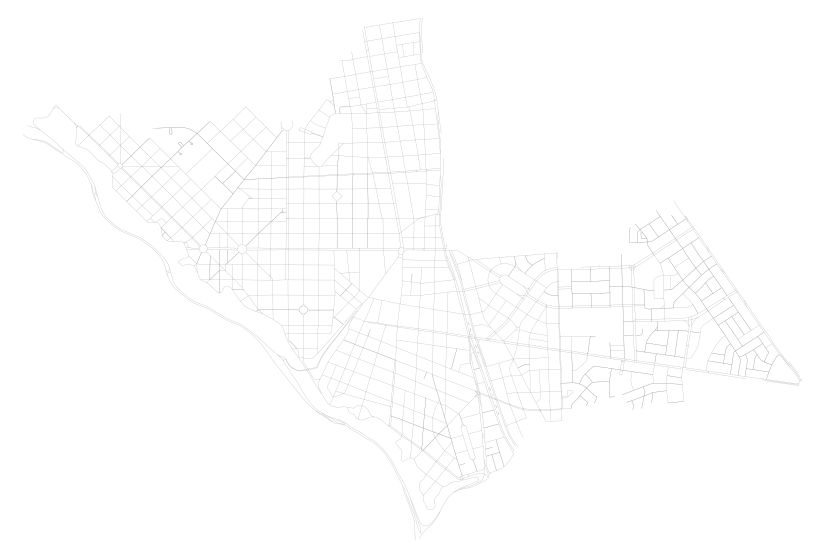

In [11]:
fig

## City's Polygon

In [12]:
pol = ox.gdf_from_place(osm_place, which_result=which_result)

In [13]:
pol.to_csv(OUTPUT_PATH / f'{city}_pol.csv')

## Pluviometry Data

In [14]:
rain = pd.read_csv(RAW_PATH/'miraflores-daily_weather.csv')

In [15]:
rain['time'] = rain['time'].apply(dt.fromisoformat).apply(dt.date).apply(pd.to_datetime)
rain = rain.set_index('time').rename_axis(index={'time':'date'})

In [16]:
rain['precipAccum'] = rain.precipIntensity * 24

We have included a temporal dependence to capture periods that there is little rainfall over a single day, but that the accumulated rainfall could cause flooding at the end of the period.

In [17]:
rain['precipAccum_D-1'] = rain.shift(1).precipAccum
rain['precipAccum_D-2'] = rain.shift(2).precipAccum

In [18]:
# If you want to check the quantiles, uncomment the line below and execute this cell
#pd.qcut(rain['precipAccum'], 5).unique()

In [19]:
rain['precipAccum_quantized'] = pd.qcut(rain['precipAccum'], 5, labels=False )

rain['precipAccum_D-1_quantized'] = rain.shift(1)['precipAccum_quantized']
rain['precipAccum_D-2_quantized'] = rain.shift(2)['precipAccum_quantized']

We added dummies to indicate if the observed day was at the weekend or not as a proxy for a smaller car flow and, therefore, fewer users using the application, which may be correlated with a smaller number of alerts reported on the day.

In [20]:
DoW = pd.get_dummies(rain.index.weekday_name)

rain['Saturday'] = DoW['Saturday'].values
rain['Sunday'] = DoW['Sunday'].values

In [21]:
rain.head(7)

,cloudCover,humidity,precipIntensity,windSpeed,precipAccum,precipAccum_D-1,precipAccum_D-2,precipAccum_quantized,precipAccum_D-1_quantized,precipAccum_D-2_quantized,Saturday,Sunday
date,,,,,,,,,,,,
2018-09-30,0.68,0.71,0.0023,3.16,0.0552,NaN,NaN,1,NaN,NaN,0,1
2018-10-01,0.88,0.72,0.0022,2.83,0.0528,0.0552,NaN,1,1.0,NaN,0,0
2018-10-02,0.82,0.73,0.0032,2.60,0.0768,0.0528,0.0552,2,1.0,1.0,0,0
2018-10-03,1.00,0.72,0.0025,2.10,0.0600,0.0768,0.0528,2,2.0,1.0,0,0
2018-10-04,0.92,0.72,0.0009,2.31,0.0216,0.0600,0.0768,0,2.0,2.0,0,0
2018-10-05,0.49,0.72,0.0035,3.03,0.0840,0.0216,0.0600,2,0.0,2.0,0,0
2018-10-06,0.90,0.72,0.0041,2.63,0.0984,0.0840,0.0216,3,2.0,0.0,1,0


# Quick Analysis and Visualizations

Let's check the number of alerts per day and distribution

In [22]:
flood.head()

,uuid,latitude,longitude,interactions,street,reliability,start_time,end_time,share,cum_share,geometry,date
0,5f8a9ee4-cbfd-3b1e-b10f-861d0c1af10b,-12.132533,-77.031029,25,Vía Expresa Costa Verde,10,2019-02-03 03:25:00.000,2019-02-03 04:51:00.000,0.0229,0.022915,POINT (-77.031029 -12.132533),2019-02-03
1,c94d5b4a-974f-3550-ab60-39a507c0bf5c,-12.133135,-77.030389,23,Vía Expresa Costa Verde,10,2019-02-09 00:56:00.000,2019-02-09 01:42:00.000,0.0211,0.043996,POINT (-77.030389 -12.133135),2019-02-09
2,a388e8ae-f3d9-3658-9f14-2e9db42892a4,-12.131729,-77.029708,21,Av. Armendáriz,10,2019-05-14 20:34:00.000,2019-05-14 21:52:00.000,0.0192,0.063245,POINT (-77.029708 -12.131729),2019-05-14
3,96a3dd01-3d0d-325a-8cb3-c5025e79db20,-12.132819,-77.030705,20,Vía Expresa Costa Verde,10,2019-03-01 03:53:00.000,2019-03-01 04:40:00.000,0.0183,0.081577,POINT (-77.03070500000001 -12.132819),2019-03-01
4,3a936507-35e4-3efb-99d4-a94dda397ac5,-12.132326,-77.031355,18,Vía Expresa Costa Verde,10,2019-02-09 02:32:00.000,2019-02-09 04:04:00.000,0.0165,0.098075,POINT (-77.031355 -12.132326),2019-02-09


In [23]:
date_flood = (flood[['date','interactions']].groupby(['date'])
              .agg(['count','sum'])
              .droplevel(0, axis=1)
              .rename(columns={'count':'alerts', 'sum':'interactions'})
              .sort_values('alerts', ascending=False))

In [24]:
date_flood.alerts.describe()

count    104.000000
mean       2.057692
std        1.767160
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       11.000000
Name: alerts, dtype: float64

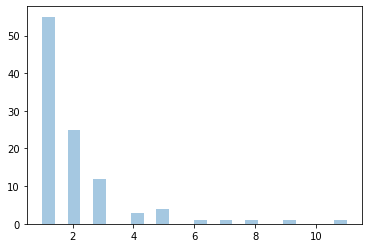

In [25]:
sns.distplot(date_flood.alerts.values, kde=False);

# Modelling on Day level

## Preparing Dataset

In [26]:
rain.head(2)

,cloudCover,humidity,precipIntensity,windSpeed,precipAccum,precipAccum_D-1,precipAccum_D-2,precipAccum_quantized,precipAccum_D-1_quantized,precipAccum_D-2_quantized,Saturday,Sunday
date,,,,,,,,,,,,
2018-09-30,0.68,0.71,0.0023,3.16,0.0552,NaN,NaN,1,NaN,NaN,0,1
2018-10-01,0.88,0.72,0.0022,2.83,0.0528,0.0552,NaN,1,1.0,NaN,0,0


In [27]:
flood.head(2)

,uuid,latitude,longitude,interactions,street,reliability,start_time,end_time,share,cum_share,geometry,date
0,5f8a9ee4-cbfd-3b1e-b10f-861d0c1af10b,-12.132533,-77.031029,25,Vía Expresa Costa Verde,10,2019-02-03 03:25:00.000,2019-02-03 04:51:00.000,0.0229,0.022915,POINT (-77.031029 -12.132533),2019-02-03
1,c94d5b4a-974f-3550-ab60-39a507c0bf5c,-12.133135,-77.030389,23,Vía Expresa Costa Verde,10,2019-02-09 00:56:00.000,2019-02-09 01:42:00.000,0.0211,0.043996,POINT (-77.030389 -12.133135),2019-02-09


In [28]:
day_grouped = flood[['interactions', 'date']].groupby('date')

data_day = (day_grouped.agg({'interactions':['count','sum']})
            .droplevel(0, axis=1)
            .rename(columns={'count':'alerts', 'sum':'interactions'}))

In [29]:
days_flooded_set = set(data_day.index.to_series().apply(lambda x: dt.date(x.to_pydatetime())).to_list())

In [30]:
rain['dayFlooded'] = pd.Series(rain.index.map(lambda i: dt.date(i.to_pydatetime()) in days_flooded_set)).values
rain['prevDayFlooded'] = rain.shift(1).dayFlooded

In [31]:
data_day = rain.join(data_day, how='outer')

data_day[['alerts', 'interactions']] = data_day[['alerts','interactions']].fillna(value=0)
data_day['target'] = (data_day['alerts'] > 0).apply(int)

Creating a copy o data_day in order to train and test a prediction model of flood occurrences

In [32]:
data_day1 = data_day.drop(columns=['interactions','alerts','dayFlooded',
                                   'precipAccum','precipAccum_D-1','precipAccum_D-2', 
                                   'precipIntensity'])

In [33]:
data_day1.head()

,cloudCover,humidity,windSpeed,precipAccum_quantized,precipAccum_D-1_quantized,precipAccum_D-2_quantized,Saturday,Sunday,prevDayFlooded,target
date,,,,,,,,,,
2018-09-30,0.68,0.71,3.16,1,NaN,NaN,0,1,NaN,0
2018-10-01,0.88,0.72,2.83,1,1.0,NaN,0,0,False,0
2018-10-02,0.82,0.73,2.60,2,1.0,1.0,0,0,False,1
2018-10-03,1.00,0.72,2.10,2,2.0,1.0,0,0,True,0
2018-10-04,0.92,0.72,2.31,0,2.0,2.0,0,0,False,0


In [34]:
data_day1 = data_day1.dropna()

In [35]:
print("Total days on dataset:", data_day1.shape[0])
print("Days with flood alerts:",data_day1[data_day1['target']==1].shape[0])
print("Days without flood alerts:",data_day1[data_day1['target']==0].shape[0])

Total days on dataset: 328
Days with flood alerts: 104
Days without flood alerts: 224


It seems that our data is unbalanced. That is something we must account for

In [36]:
X_train, X_test, y_train, y_test = train_test_split(data_day1.drop('target',axis=1), data_day1['target'], 
                                                    test_size=0.30, random_state=42)

## Logistic Regression

### Stats Model

In [37]:
X_train = X_train.astype({'prevDayFlooded': 'uint8'})

In [38]:
logit_model_sm=sm.Logit(y_train, X_train)
result=logit_model_sm.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.584283
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                  229
Model:                          Logit   Df Residuals:                      220
Method:                           MLE   Df Model:                            8
Date:                Mon, 16 Sep 2019   Pseudo R-squ.:                 0.03335
Time:                        11:49:24   Log-Likelihood:                -133.80
converged:                       True   LL-Null:                       -138.42
Covariance Type:            nonrobust   LLR p-value:                    0.3230
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
cloudCover                    1.4049      0.704      1.996      0.046       0.

### Scikit Learn

Note that by default, sklearn LogisticRegression model does a L2 Regularization

In [39]:
logit_model = LogisticRegression(class_weight='balanced').fit(X_train, y_train)

Classification Report
              precision    recall  f1-score   support

   No Floods       0.71      0.65      0.68        62
     Flooded       0.49      0.57      0.53        37

    accuracy                           0.62        99
   macro avg       0.60      0.61      0.60        99
weighted avg       0.63      0.62      0.62        99

ROC Score: 0.606364428945074
Accuracy Score: 0.6161616161616161
Average Precision Score: 0.4388003225212528
f1 Score: 0.525
Confusion matrix, without normalization
[[40 22]
 [16 21]]


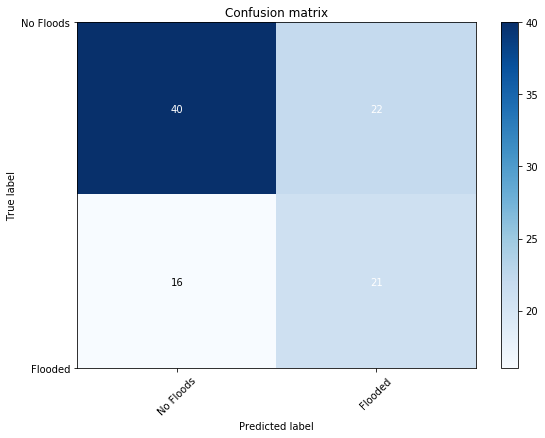

In [40]:
roc = clf_eval(logit_model, X_test, y_test)

Sunday                      -0.312181
humidity                    -0.217426
precipAccum_quantized       -0.150406
prevDayFlooded              -0.052518
precipAccum_D-2_quantized   -0.045142
windSpeed                   -0.016391
precipAccum_D-1_quantized    0.004233
Saturday                     0.213578
cloudCover                   0.949169
dtype: float64


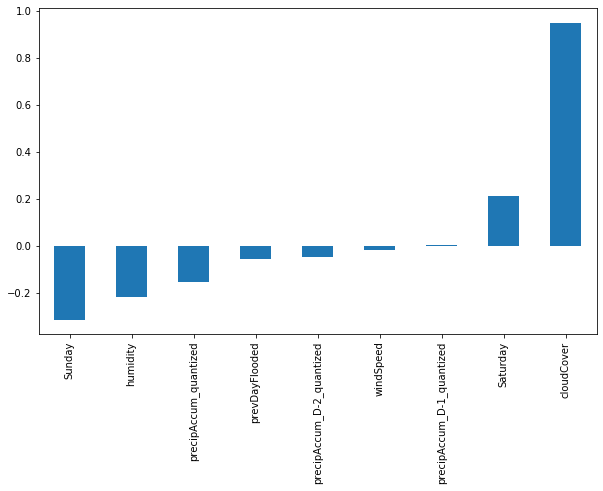

In [41]:
coefs = pd.Series(logit_model.coef_[0], index=X_train.columns)
coefs = coefs.sort_values()
coefs.plot(kind="bar", figsize=(10,6))
print(coefs.sort_values(ascending = True))

# Kernel Density Estimation on Linear Network

In addition to trying to identify days when flooding may occur, we also want to identify where in the city flooding is most likely to occur.

Our approach was to adopt a non-parametric model for estimating the density of alerts. The model estimates in the linear network and identifies which streets are more likely to have floods.

## Matching Alerts to Streets in Graph

First, we must match the alerts to the city's graph structure obtained from OSM.

In [42]:
# We use projected graph for better accuracy in KDTree method
edges_with_potholes = phc.match_roads_to_points(city, flood, G_proj)

In [43]:
nx.set_edge_attributes(G_proj, 0, 'alerts_count')
nx.set_edge_attributes(G_proj, 0, 'interactions')
nx.set_edge_attributes(G_proj, edges_with_potholes)

In [44]:
nx.set_edge_attributes(G, 0, 'alerts_count')
nx.set_edge_attributes(G, 0, 'interactions')
nx.set_edge_attributes(G, edges_with_potholes)

In [45]:
### Feito o match, iremos analisar os segmentos com os buracos
nodes, edges = ox.graph_to_gdfs(G_proj) 

The image below shows all street sections where flood alerts have been reported, in which the colors indicates the amount of interactions of app users with such alerts.

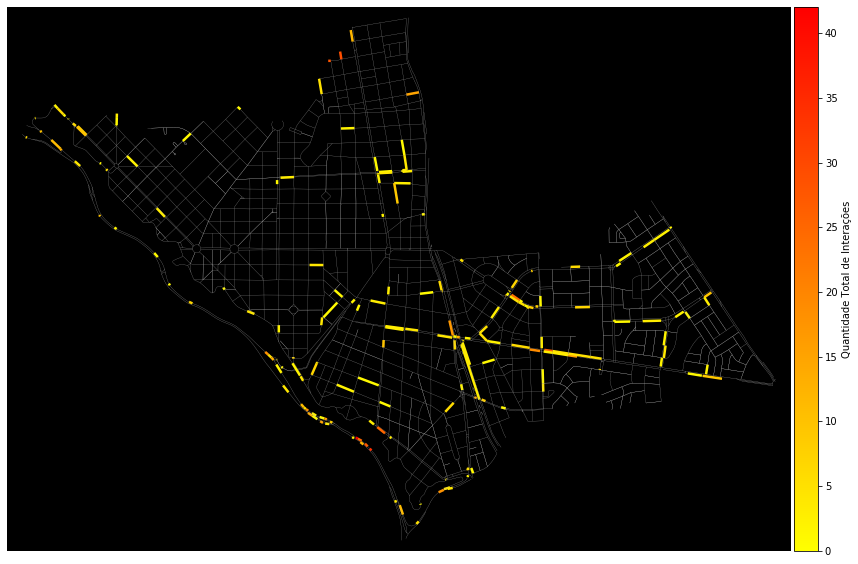

In [46]:
phc.plot_graph_potholes(G_proj, fig_width=None)

## Density Estimation

In [47]:
nodes_xy = nodes.reset_index()[['x','y']]

In [48]:
bbox = gpd.GeoSeries(box(pol.loc[0,'bbox_west'],pol.loc[0,'bbox_south'],pol.loc[0,'bbox_east'],pol.loc[0,'bbox_north']),
                crs='+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs').to_crs(G_proj.graph['crs'])[0].bounds

(xmin, ymin, xmax, ymax) = bbox

In [49]:
node_index = nodes.reset_index(drop=True).reset_index().set_index('osmid')['index'].to_dict()

edges_list = edges[['u','v']]

edges_list['U'] = edges.u.apply(lambda u: node_index[u])
edges_list['V'] = edges.v.apply(lambda u: node_index[u])

edges_list = edges_list[['U','V']]
edges_list = edges_list + 1 

In [50]:
flood['point_proj_on_edge'] = phc.project_alert_on_nearest_edge(city, flood, G_proj)

flood['X'] = flood['point_proj_on_edge'].apply(lambda point: point.x)
flood['Y'] = flood['point_proj_on_edge'].apply(lambda point: point.y)

alerts_xy = flood[['X','Y']]

In [51]:
%%R
library(spatstat)

R[write to console]: Loading required package: spatstat.data

R[write to console]: Loading required package: nlme

R[write to console]: Loading required package: rpart

R[write to console]: 
spatstat 1.60-1.035       (nickname: ‘Watch out for that ... tree’) 
For an introduction to spatstat, type ‘beginner’ 




In [52]:
%%R -i nodes_xy,xmin,xmax,ymin,ymax,edges_list,alerts_xy

#install.packages('spatstat', repos='http://cran.us.r-project.org', quiet=TRUE)

vertices <- as.ppp(nodes_xy, c(xmin, xmax, ymin, ymax))
edges <- as.matrix(edges_list)
L <- linnet(vertices, edges=edges, sparse=TRUE)

In [53]:
%%R

pplinnet <- lpp(alerts_xy, L)

We are using gaussian kernels and using sigma=1000 just for illustration.

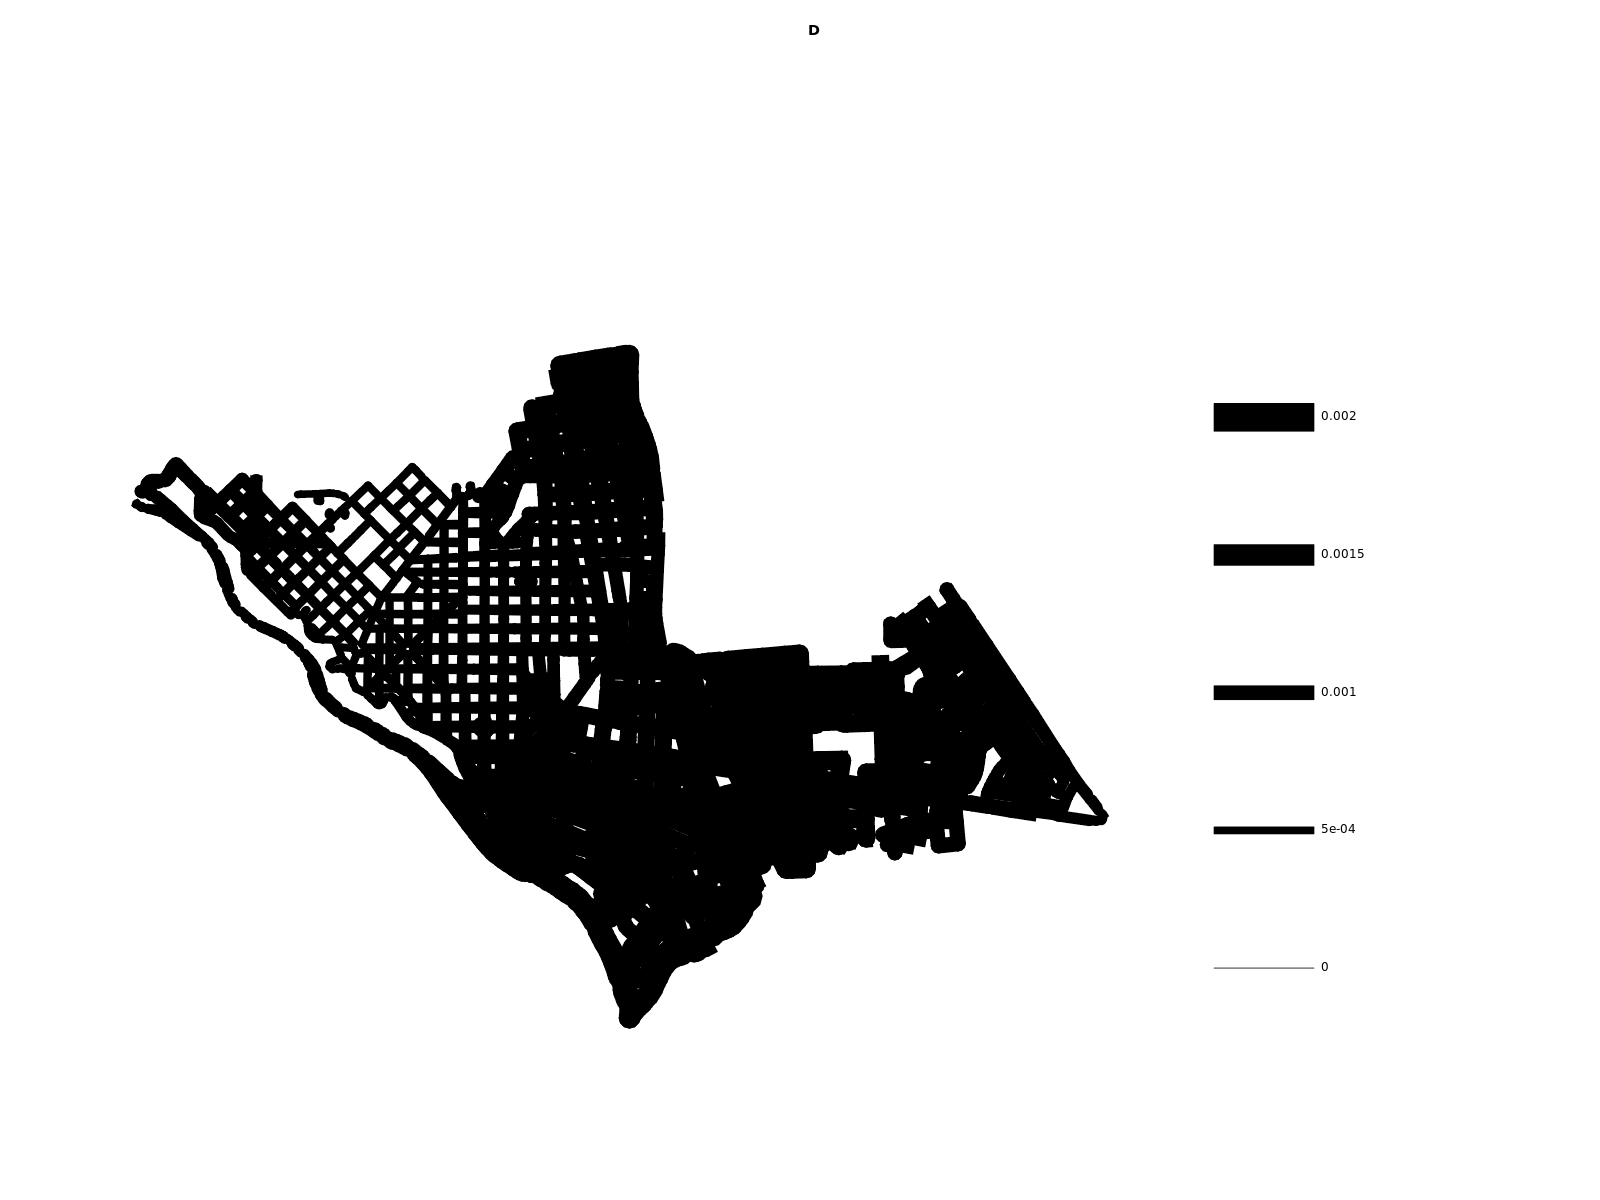

In [54]:
%%R -h 1200 -w 1600

D <- density(pplinnet, 1000, verbose=FALSE)

plot(D, style="w")

Sigma has a major role in the kernel density estimation. One way to pick a good value for it is using cross-validation. Here, we are using CV in kernel density estimation based on euclidian distances. It is not the best approach, but a good first one.

In [55]:
%%R

Dquick <- density(pplinnet, distance="euclidean", at="points")
#sessionInfo()

In [56]:
%%R
print(attributes(Dquick)$sigma)

[1] 521.4992


The plot below is the our kernel density estimation using cross-validated sigma.

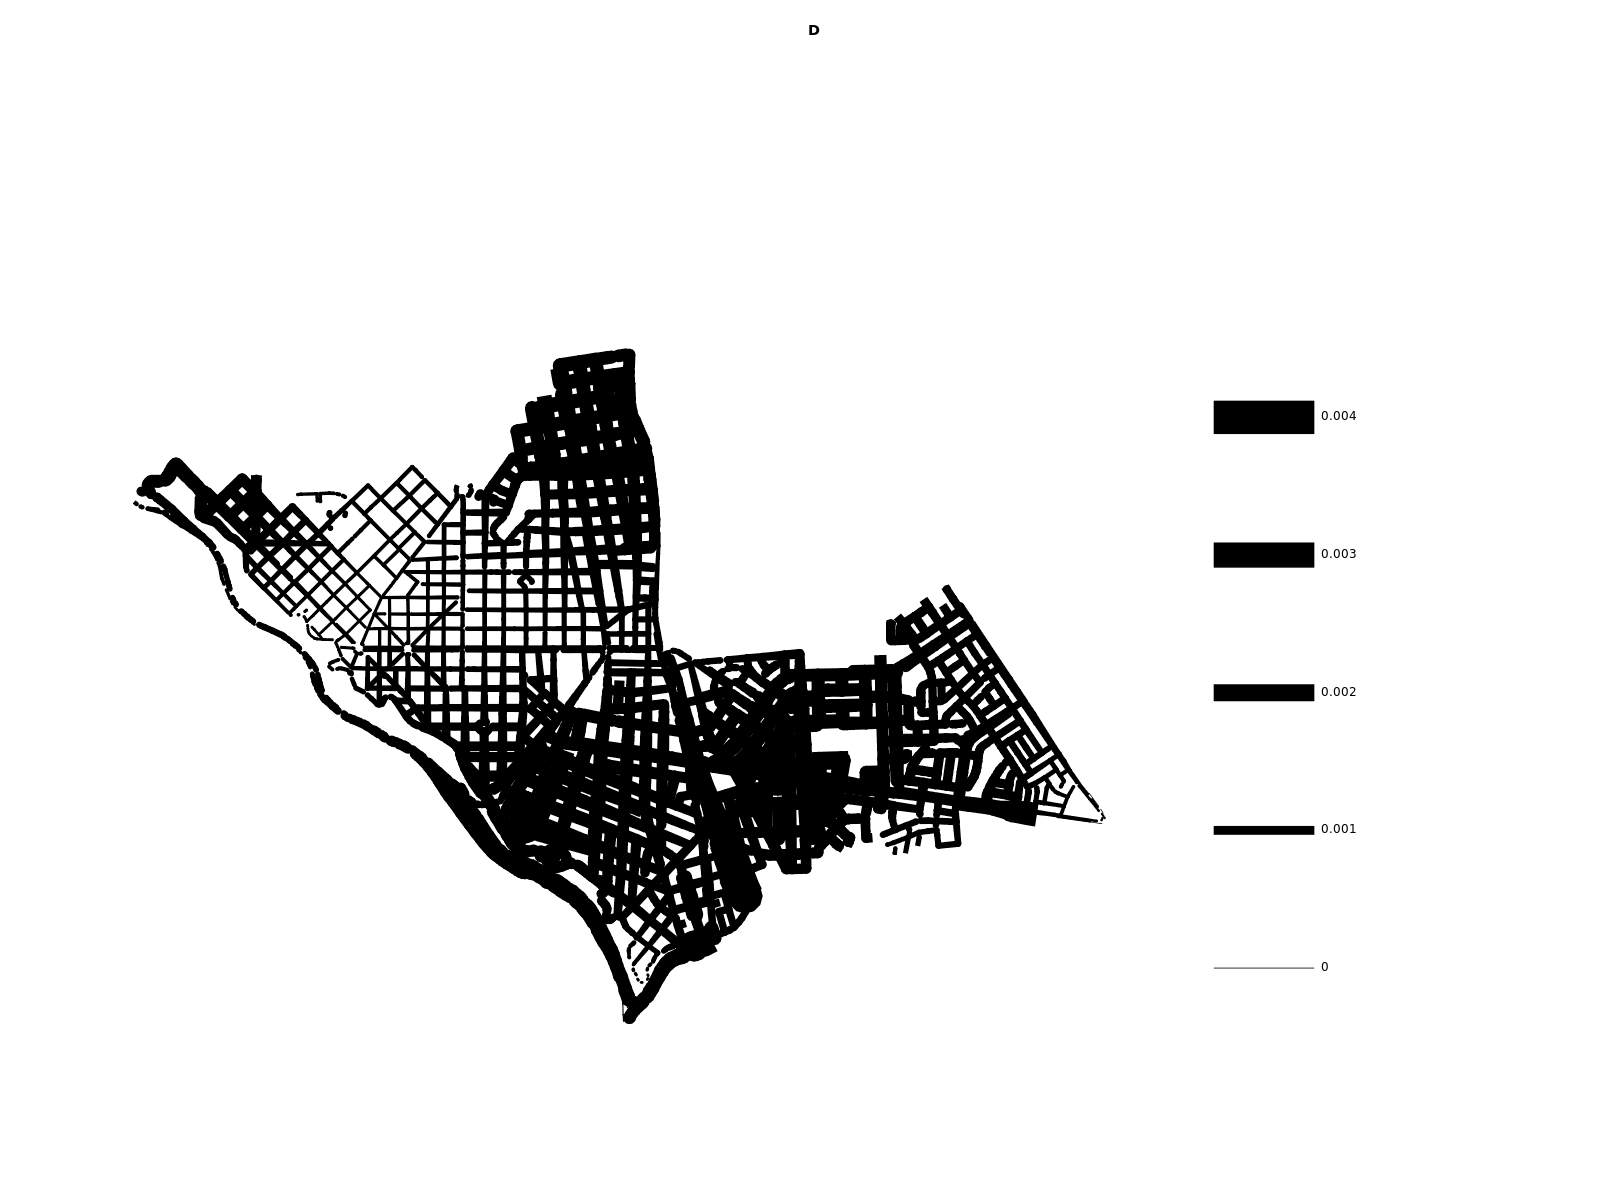

In [57]:
%%R -h 1200 -w 1600

D <- density(pplinnet, attributes(Dquick)$sigma, verbose=FALSE)

plot(D, style="w")